## Data Exploration

This script illustrates how to load, visualize the data and perform some basic exploratory data analysis.

In [1]:
import numpy as np
import fncs
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

### Analyzing Data over a Single Trial

Loading the data.

In [2]:
dataFolder = dirTrain = "../data/train/"
xt, xv, yt, yv = fncs.loadTrial(dataFolder, id=1)

Plotting the measurements and labels.

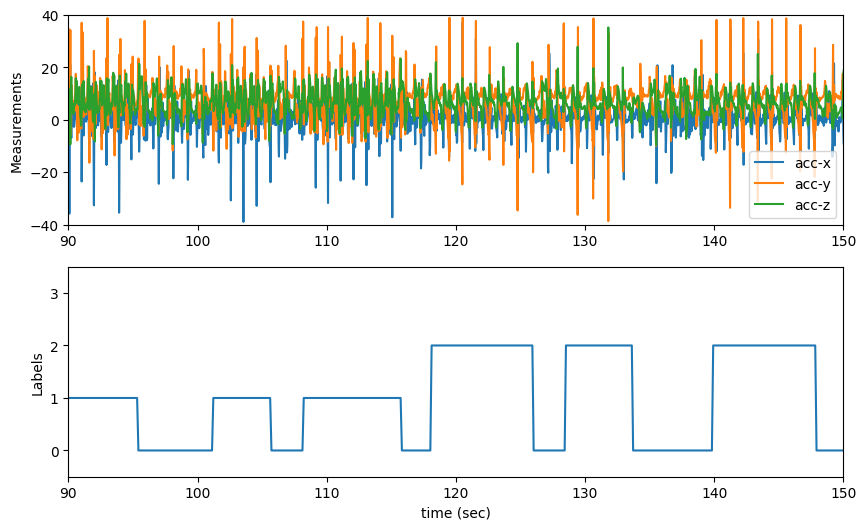

Labels include the following Locomotion Modes:
(0) Standing / Walking Hard Terrain
(1) Climbing Down Stairs
(2) Climbing Up Stairs
(3) Walking Soft Terrain


In [3]:
# Specifying a window of time for display
t_min = 90
t_max = 150

# Plotting the data
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(10, 6)

ax1.plot(xt, xv[:, 0:3])
ax1.axis([t_min, t_max, -40, 40])
ax1.set_ylabel("Measurements")
ax1.legend(["acc-x", "acc-y", "acc-z"])

ax2.plot(yt, yv)
ax2.axis([t_min, t_max, -0.5, 3.5])
ax2.set_xlabel("time (sec)")
ax2.set_ylabel("Labels")

plt.show()

# Displaying the labels
print("Labels include the following Locomotion Modes:")
print("(0) Standing / Walking Hard Terrain")
print("(1) Climbing Down Stairs")
print("(2) Climbing Up Stairs")
print("(3) Walking Soft Terrain")

Compute the mean and standard deviation of the period between samples to make sure that they match with the description.

In [4]:
dxt = np.diff(xt)
print(
    "Timestamps for x: Mean = {:5.3f} | Std = {:5.3f}".format(np.mean(dxt), np.std(dxt))
)

dyt = np.diff(yt)
print(
    "Timestamps for y: Mean = {:5.3f} | Std = {:5.3f}".format(np.mean(dyt), np.std(dyt))
)

Timestamps for x: Mean = 0.025 | Std = 0.000
Timestamps for y: Mean = 0.100 | Std = 0.000


Displaying the histogram of labels. Not that this distribution is imbalanced. You may need to consider techniques for handling this during your model selection.

In [5]:
# 'yCounts' should be a list with 4 entries containing the counts for each class from 'yv'.
yCounts = []

###
### YOUR CODE HERE
###
yCounts = [np.sum(yv == 0), np.sum(yv == 1), np.sum(yv == 2), np.sum(yv == 3)]

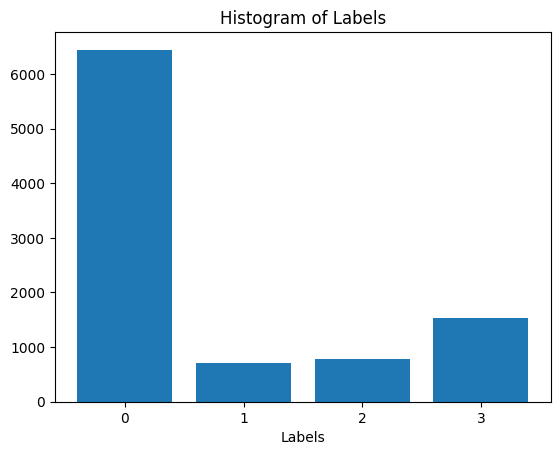

In [6]:
# Plottinng the counts
plt.bar([0, 1, 2, 3], yCounts)
plt.xticks([0, 1, 2, 3])
plt.xlabel("Labels")
plt.title("Histogram of Labels")
plt.show()

In [7]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###

Extracting some hand-crafted features and displaying a correlogram of these values.

In [8]:
# This function extracts features from the measurements.
def extractFeat(xt, xv, winSz, timeStart, timeEnd, timeStep):
    tList = []
    featList = []

    # Specifying the initial window for extracting features
    t0 = timeStart
    t1 = t0 + winSz

    while t1 <= timeEnd:
        # Using the middle time of the window as a reference time
        tList.append((t0 + t1) / 2)

        # Extracting features. First, extract a window from the data that consists on the
        # measurements that are exactly in the interval [t0,t1]. Then, let 'f1' be the means of the
        # features, and 'f2' be the standard deviation of the window of values extracted. Each one
        # of 'f1' and 'f2' should have the same length as the number of columns in 'xv'.
        ###
        ### YOUR CODE HERE
        ###
        mask = (xt >= t0) & (xt <= t1)
        xw = xv[mask]
        f1 = np.mean(xw, axis=0)
        f2 = np.std(xw, axis=0)

        # Storing the features
        featList.append(np.concatenate((f1, f2)))

        # Updating the window by shifting it by the step size
        t0 = t0 + timeStep
        t1 = t0 + winSz

    tList = np.array(tList)
    featList = np.array(featList)

    return tList, featList

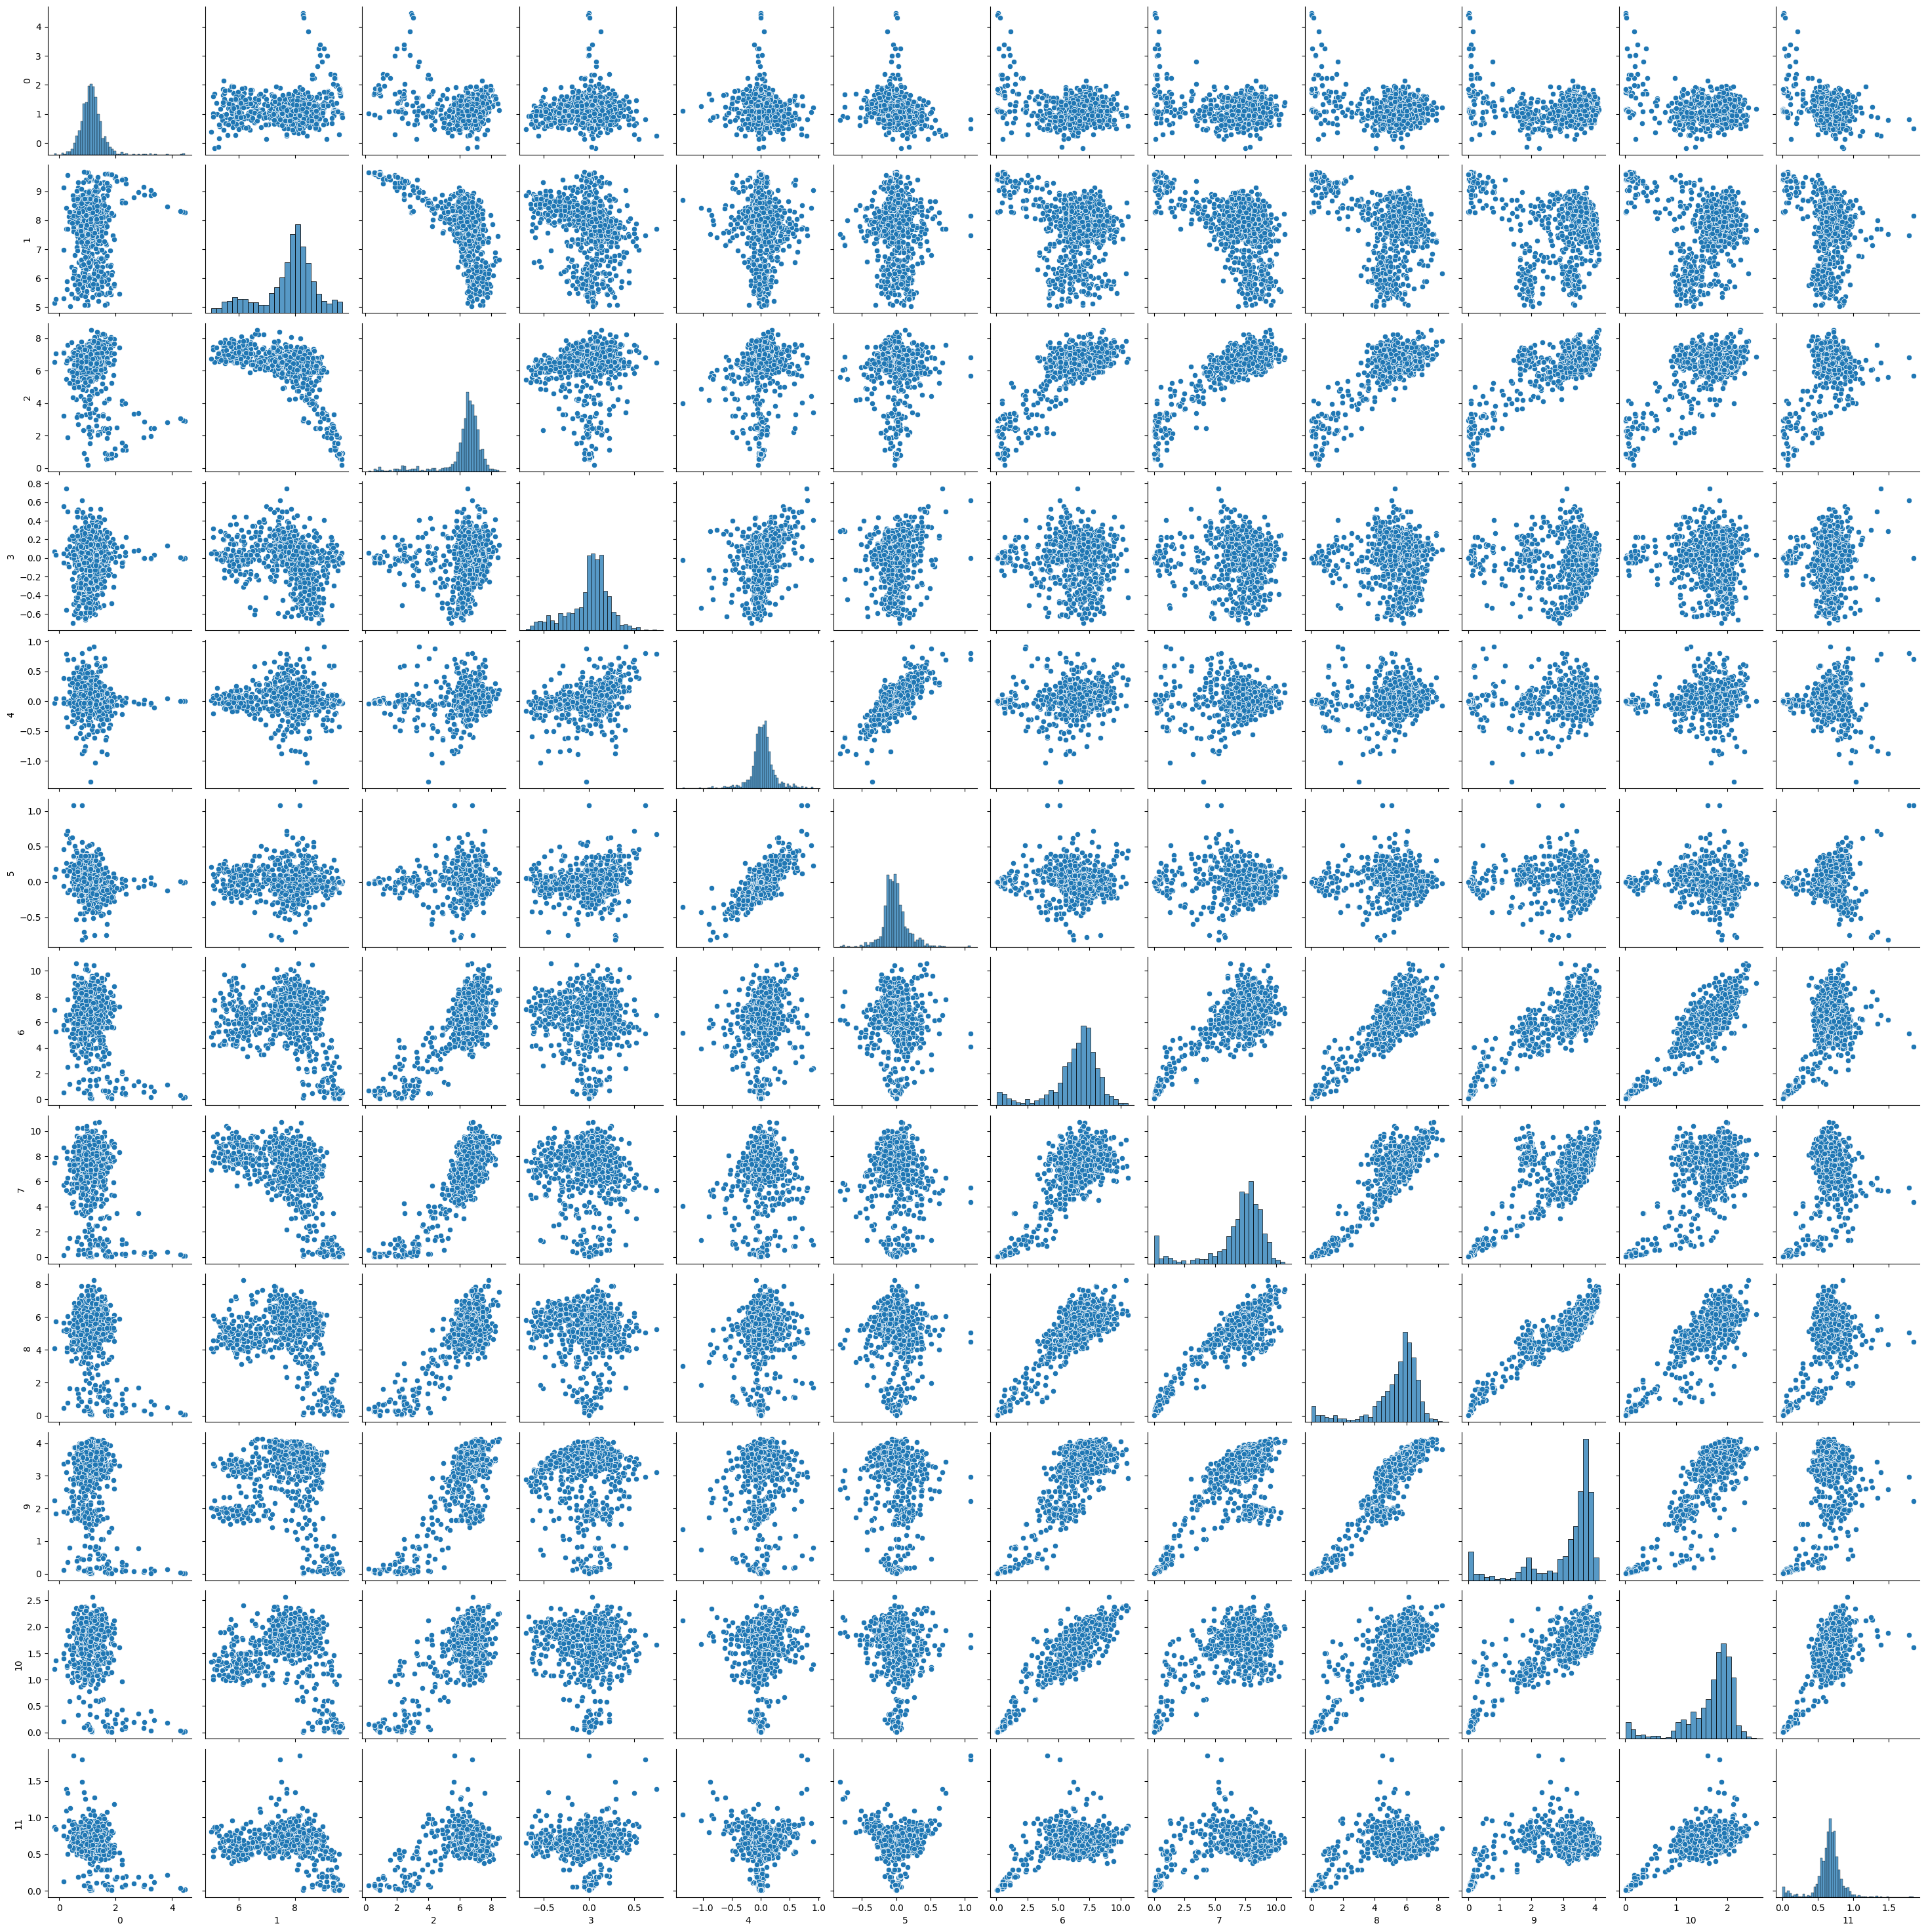

In [9]:
# Specifying some parameters for the feature extraction
timeStart = np.min(xt)  # Starting time for the first window
timeEnd = np.max(xt)  # The windows cannot go beyond the end time
timeStep = 1  # The step size used to shift the windows
winSz = 2  # The size of a window for feature extraction

# Getting the features
tList, featList = extractFeat(xt, xv, winSz, timeStart, timeEnd, timeStep)

# Displaying a correlogram
import seaborn as sns
import pandas as pd

sns.pairplot(pd.DataFrame(featList))
plt.show()

In [10]:
assert (
    featList.shape[0] == 946
), "The number of windows is incorrect. You may have change the code in an inappropriate location."
assert featList.shape[1] == 12, "You are not extracting the correct numbef of features."

In [11]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###

It can be observed that some of the features seem to be failry correlated. This could be used to for feature selection if needed. Also, the range of the values have a different of a factor over 10 in some cases, which may indicate the need for feature normalization.

### Analyzing Data over Entire Dataset

We extract summaries for each one of the features.

In [12]:
dataFolder = dirTrain = "../data/train/"

# Specifying some parameters for the feature extraction
timeStep = 1
winSz = 2

for id in range(29):
    # Loading data and extracting features
    xt, xv, yt, yv = fncs.loadTrial(dataFolder, id=id + 1)
    timeStart = np.min(xt)
    timeEnd = np.max(xt)
    tList, featList = extractFeat(xt, xv, winSz, timeStart, timeEnd, timeStep)

    # Extracting some summaries
    yCounts, bin_edges = np.histogram(yv, bins=[-0.5, 0.5, 1.5, 2.5, 3.5])

    # Storing values for analysis
    if id == 0:
        ySummary = np.array([yCounts / sum(yCounts)])
        featSummary = np.array([np.mean(featList, axis=0)])
    else:
        ySummary = np.concatenate(
            (ySummary, np.array([yCounts / sum(yCounts)])), axis=0
        )
        featSummary = np.concatenate(
            (featSummary, np.array([np.mean(featList, axis=0)])), axis=0
        )

Plotting the distribution of the per-trial frequencies of labels.

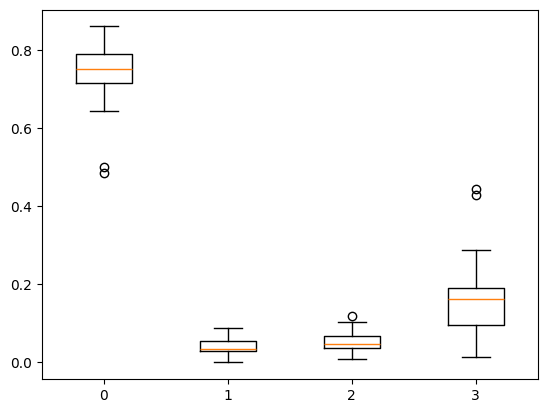

In [13]:
plt.boxplot(ySummary)
plt.xticks([1, 2, 3, 4], [0, 1, 2, 3])
plt.show()

Plotting the distribution of the average (over trial) features.

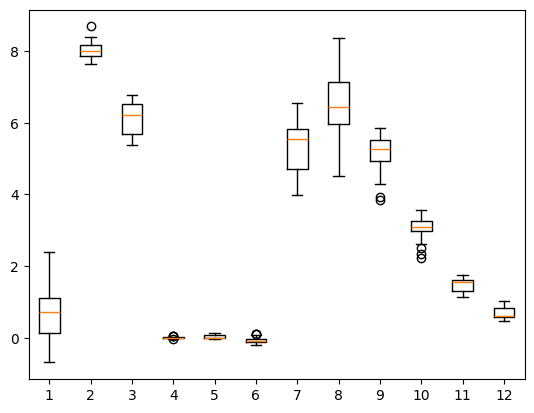

In [14]:
# We are normalizing over

plt.boxplot(featSummary)
plt.show()

From these plots, we observe that there is some variability on the distributions but overall consistent trends.